# Setup Ambiente

In [1]:
#!pip install firebase_admin pandas matplotlib seaborn --quiet

# Connessione a Firestore


In [2]:
import firebase_admin
from firebase_admin import credentials, firestore
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
import plotly.graph_objects as go
from prophet.plot import plot_plotly
import warnings

# Ignora i warning di pandas per una visualizzazione più pulita
warnings.filterwarnings('ignore')

In [3]:
# Inizializzazione Firebase Admin SDK
# Sostituisci il "path" con il percorso al tuo file di credenziali Firebase
cred = credentials.Certificate("baris-iot-vito-firebase-adminsdk-baww0-19695e55a0.json")
firebase_admin.initialize_app(cred)
db = firestore.client()

# Estrazione Dati

## Prenotazioni

In [4]:
devices_ref = db.collection('devices')
devices_docs = devices_ref.stream()

all_bookings = []
for device in devices_docs:
    curr_device_id = device.id
    prenotazioni_ref = db.collection('devices').document(curr_device_id).collection('prenotazioni')
    docs = prenotazioni_ref.stream()

    for doc in docs:
        d = doc.to_dict()
        d['booking_id'] = doc.id
        d['device_id'] = curr_device_id
        # Conversione date
        if 'start_time' in d:
            d['start_time'] = pd.to_datetime(d['start_time'], utc=True, errors='coerce')
        if 'end_time' in d:
            d['end_time'] = pd.to_datetime(d['end_time'], utc=True, errors='coerce')
        all_bookings.append(d)

all_bookings_df = pd.DataFrame(all_bookings)
if 'start_time' in all_bookings_df and all_bookings_df['start_time'].dtype == 'datetime64[ns, UTC]':
    all_bookings_df['start_time'] = all_bookings_df['start_time'].dt.tz_convert(None)
if 'end_time' in all_bookings_df and all_bookings_df['end_time'].dtype == 'datetime64[ns, UTC]':
    all_bookings_df['end_time'] = all_bookings_df['end_time'].dt.tz_convert(None)

all_bookings_df.head()



,start_time,user_id,end_time,booking_id,device_id
0,2024-12-18 19:55:00,rYRiHUTLmVWAthnuaBXrx0dlHT02,2024-12-19 19:55:00,B89r3o17ppQUMpx7KiO2,iliadbox-77F2A2
1,2024-12-16 23:15:00,rYRiHUTLmVWAthnuaBXrx0dlHT02,2024-12-17 23:15:00,uZjKuwSLXBGkDGciWubU,iliadbox-77F2A2


## Analisi prenotazioni

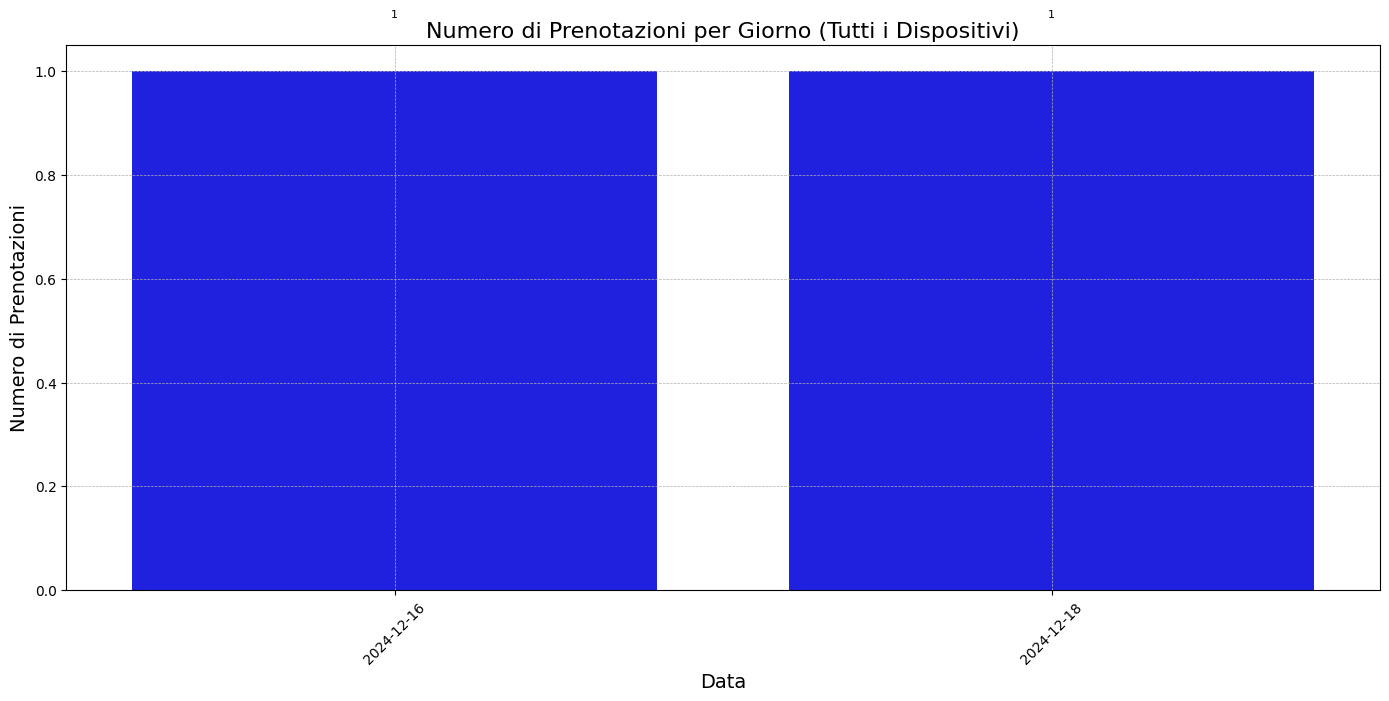

Durata media globale delle prenotazioni: 24.00 ore


In [5]:
if 'start_time' in all_bookings_df.columns:
    all_bookings_df['date'] = all_bookings_df['start_time'].dt.date
    daily_bookings = all_bookings_df.groupby('date')['booking_id'].count().reset_index(name='count')

    plt.figure(figsize=(14,7))
    ax = sns.barplot(x='date', y='count', data=daily_bookings, color='blue')
    plt.xticks(rotation=45)
    plt.title("Numero di Prenotazioni per Giorno (Tutti i Dispositivi)", fontsize=16)
    plt.xlabel("Data", fontsize=14)
    plt.ylabel("Numero di Prenotazioni", fontsize=14)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()

    # Annotazioni su ogni barra per mostrare il numero di prenotazioni
    for p in ax.patches:
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.text(x, y+0.1, str(int(y)), ha='center', va='bottom', fontsize=8, color='black')

    plt.show()

# Durata media prenotazioni globali
if 'start_time' in all_bookings_df.columns and 'end_time' in all_bookings_df.columns:
    if 'duration_hours' not in all_bookings_df.columns:
        all_bookings_df['duration_hours'] = (all_bookings_df['end_time'] - all_bookings_df['start_time'])/pd.Timedelta(hours=1)
        mean_duration = all_bookings_df['duration_hours'].mean()
        print(f"Durata media globale delle prenotazioni: {mean_duration:.2f} ore")



# Estrazione Access Log

In [6]:
devices_docs = devices_ref.stream()  # re-stream i dispositivi
all_logs = []
for device in devices_docs:
    curr_device_id = device.id
    access_logs_ref = db.collection('devices').document(curr_device_id).collection('access_logs')
    logs = access_logs_ref.stream()

    for doc in logs:
        d = doc.to_dict()
        d['log_id'] = doc.id
        d['device_id'] = curr_device_id
        d['timestamp'] = pd.to_datetime(d['timestamp'], utc=True, errors='coerce')
        all_logs.append(d)

logs_df = pd.DataFrame(all_logs)
if 'timestamp' in logs_df and logs_df['timestamp'].dtype == 'datetime64[ns, UTC]':
    logs_df['timestamp'] = logs_df['timestamp'].dt.tz_convert(None)

logs_df.head()


,user_id,timestamp,action,log_id,device_id
0,None,2024-12-13 18:04:43.493207,chiusa,0eu4DsNaH5Hq042qVZvj,iliadbox-77F2A2
1,None,2024-12-16 14:13:28.525768,aperta,0pLgP1unilx3dqIumwTu,iliadbox-77F2A2
2,None,2024-12-17 16:26:39.408281,allarme_on,1CjnkIVuLptVdmlsFsgi,iliadbox-77F2A2
3,rYRiHUTLmVWAthnuaBXrx0dlHT02,2024-12-11 16:55:16.321752,unlock,1D1ZOCIhtY23Ohi6OkrS,iliadbox-77F2A2
4,None,2024-12-17 19:56:38.277441,allarme_off,1gikiQT9B4YqEanio690,iliadbox-77F2A2


## Analisi log

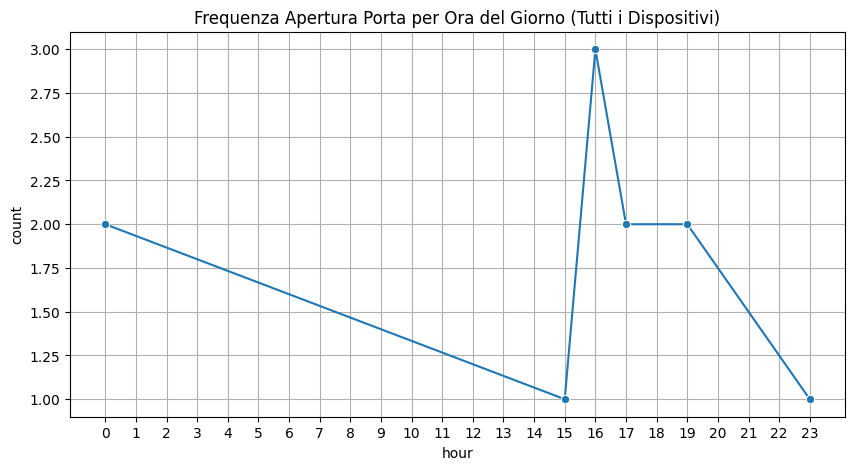

In [7]:
logs_df['hour'] = logs_df['timestamp'].dt.hour
logs_df['date'] = logs_df['timestamp'].dt.date

# Frequenza apertura porta globale
porta_aperta_df = logs_df[logs_df['action'] == 'porta aperta']
hourly = porta_aperta_df.groupby('hour').size().reset_index(name='count')

plt.figure(figsize=(10,5))
sns.lineplot(x='hour', y='count', data=hourly, marker='o')
plt.title("Frequenza Apertura Porta per Ora del Giorno (Tutti i Dispositivi)")
plt.xticks(range(0,24))
plt.grid(True)
plt.show()

## Numero di Aperture per Giorno

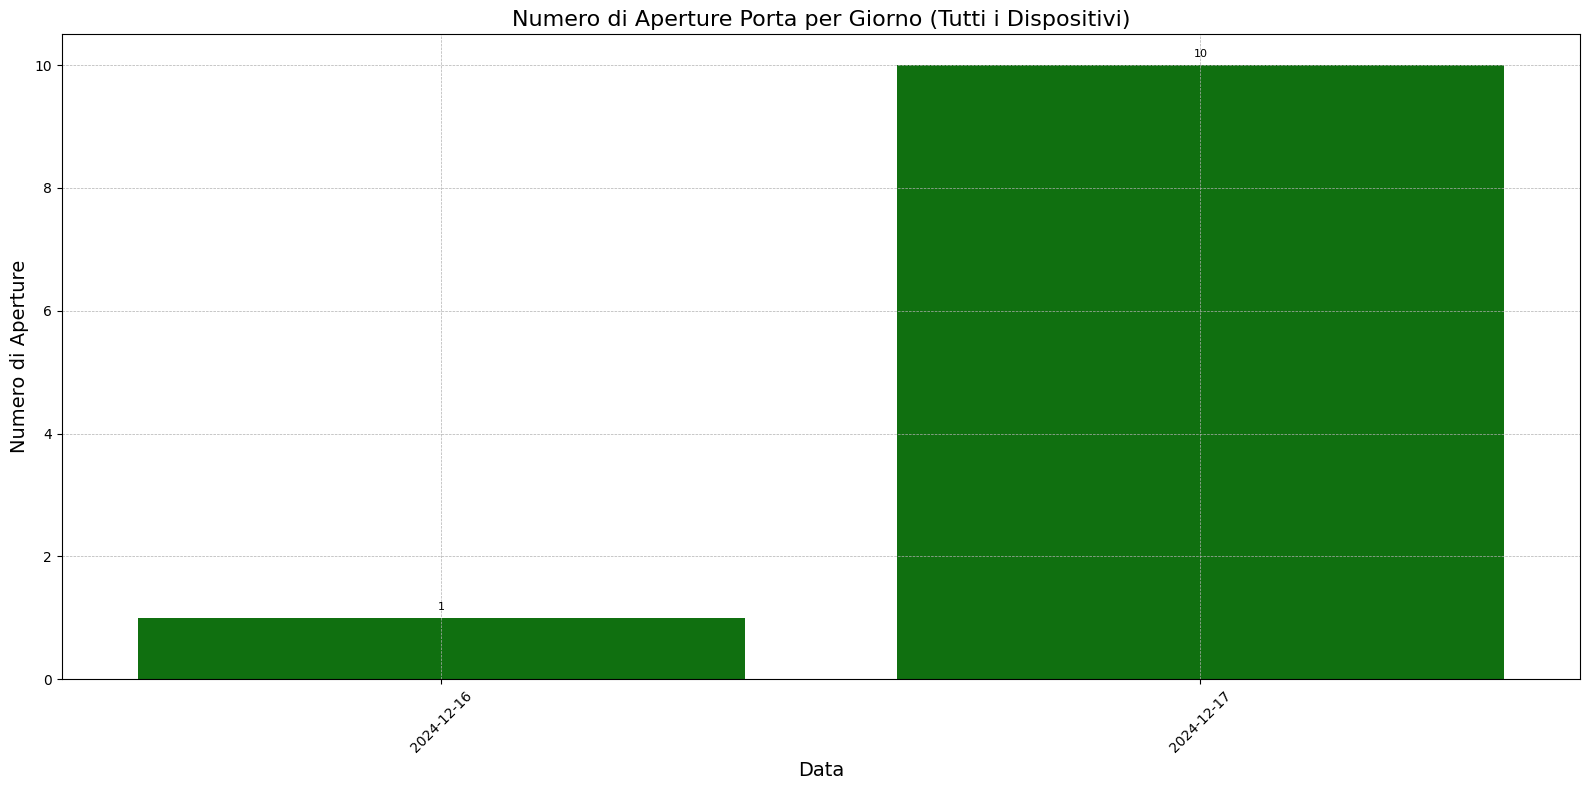

In [8]:
if 'timestamp' in logs_df.columns:
    logs_df['date'] = logs_df['timestamp'].dt.date
    aperture_df = logs_df[logs_df['action'] == 'porta aperta']
    daily_opens = aperture_df.groupby('date').size().reset_index(name='count')

    plt.figure(figsize=(16,8))
    ax = sns.barplot(x='date', y='count', data=daily_opens, color='green')
    plt.xticks(rotation=45)
    plt.title("Numero di Aperture Porta per Giorno (Tutti i Dispositivi)", fontsize=16)
    plt.xlabel("Data", fontsize=14)
    plt.ylabel("Numero di Aperture", fontsize=14)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()

    # Annotazioni su ogni barra
    for p in ax.patches:
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.text(x, y+0.1, str(int(y)), ha='center', va='bottom', fontsize=8, color='black')

    plt.show()


## Numero di Allarmi

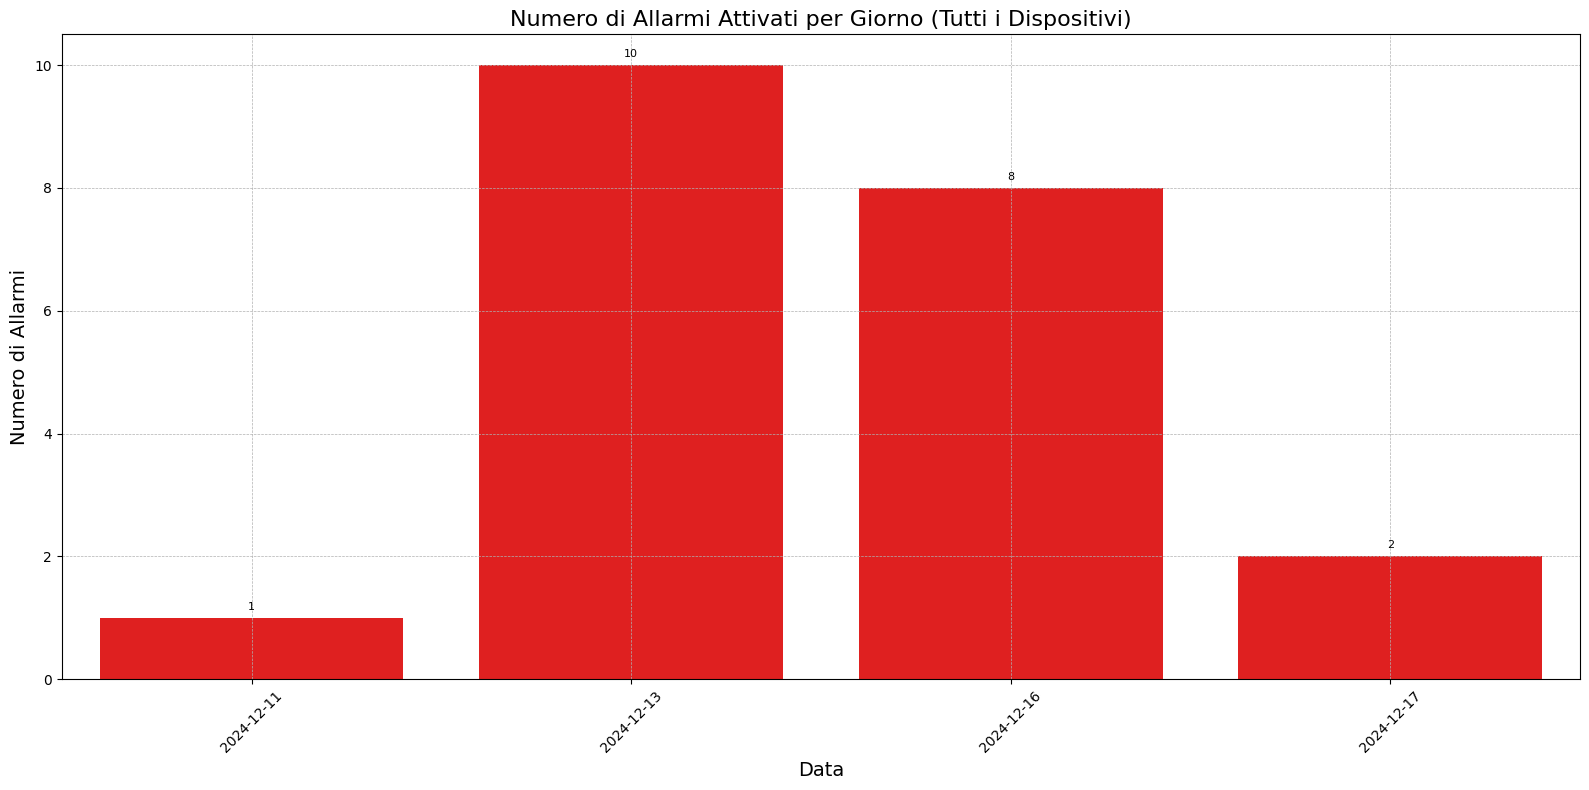

In [9]:
# Cella: Analisi degli Allarmi (aggregato)
if 'action' in logs_df.columns:
    alarms_df = logs_df[logs_df['action'].str.contains("allarme_on|EFF", case=False, na=False)]
    if not alarms_df.empty:
        alarms_df['date'] = alarms_df['timestamp'].dt.date
        alarms_per_day = alarms_df.groupby('date').size().reset_index(name='count')

        plt.figure(figsize=(16,8))
        ax = sns.barplot(x='date', y='count', data=alarms_per_day, color='red')
        plt.xticks(rotation=45)
        plt.title("Numero di Allarmi Attivati per Giorno (Tutti i Dispositivi)", fontsize=16)
        plt.xlabel("Data", fontsize=14)
        plt.ylabel("Numero di Allarmi", fontsize=14)
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.tight_layout()

        for p in ax.patches:
            x = p.get_x() + p.get_width() / 2
            y = p.get_height()
            ax.text(x, y+0.1, str(int(y)), ha='center', va='bottom', fontsize=8, color='black')

        plt.show()
    else:
        print("Nessun allarme trovato nei log.")


## Analisi per device

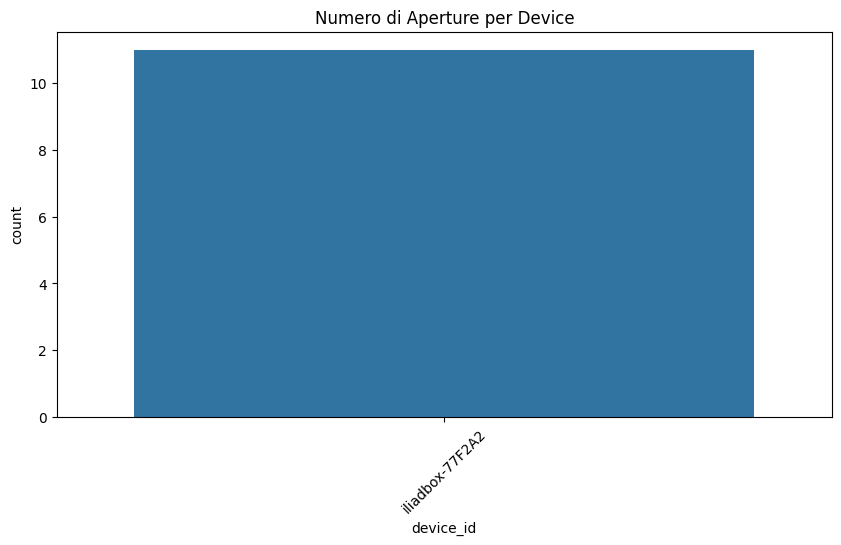

In [10]:
device_opens = porta_aperta_df.groupby('device_id').size().reset_index(name='count')
plt.figure(figsize=(10,5))
sns.barplot(x='device_id', y='count', data=device_opens)
plt.title("Numero di Aperture per Device")
plt.xticks(rotation=45)
plt.show()

# Analisi Stagionale delle Prenotazioni su Mese 

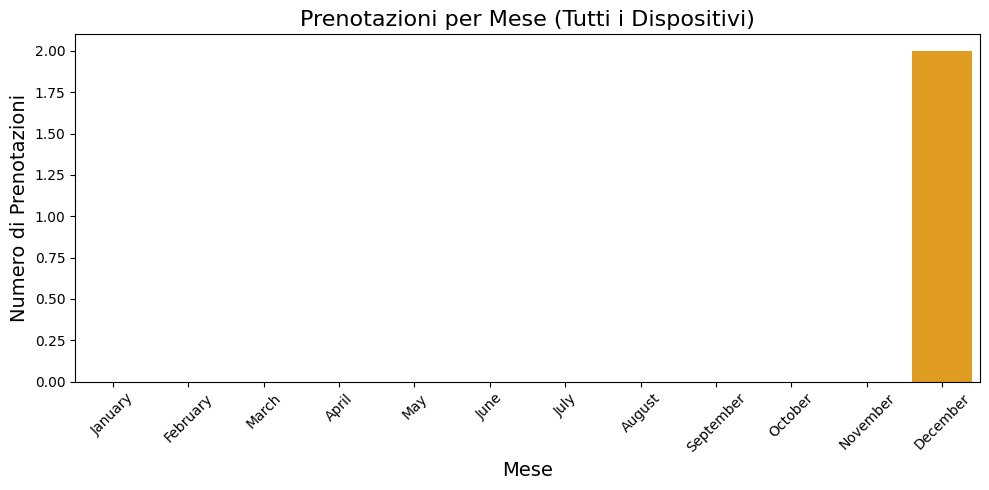

In [11]:
if 'date' in all_bookings_df.columns:
    all_bookings_df['month'] = pd.to_datetime(all_bookings_df['date']).dt.month_name()
    monthly_counts = all_bookings_df.groupby('month')['booking_id'].count().reset_index(name='count')
    order = ['January','February','March','April','May','June','July','August','September','October','November','December']

    plt.figure(figsize=(10,5))
    sns.barplot(x='month', y='count', data=monthly_counts, order=order, color='orange')
    plt.title("Prenotazioni per Mese (Tutti i Dispositivi)", fontsize=16)
    plt.xlabel("Mese", fontsize=14)
    plt.ylabel("Numero di Prenotazioni", fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Uso di ML

## Clustering dei giorni (K-Means) su Aperture

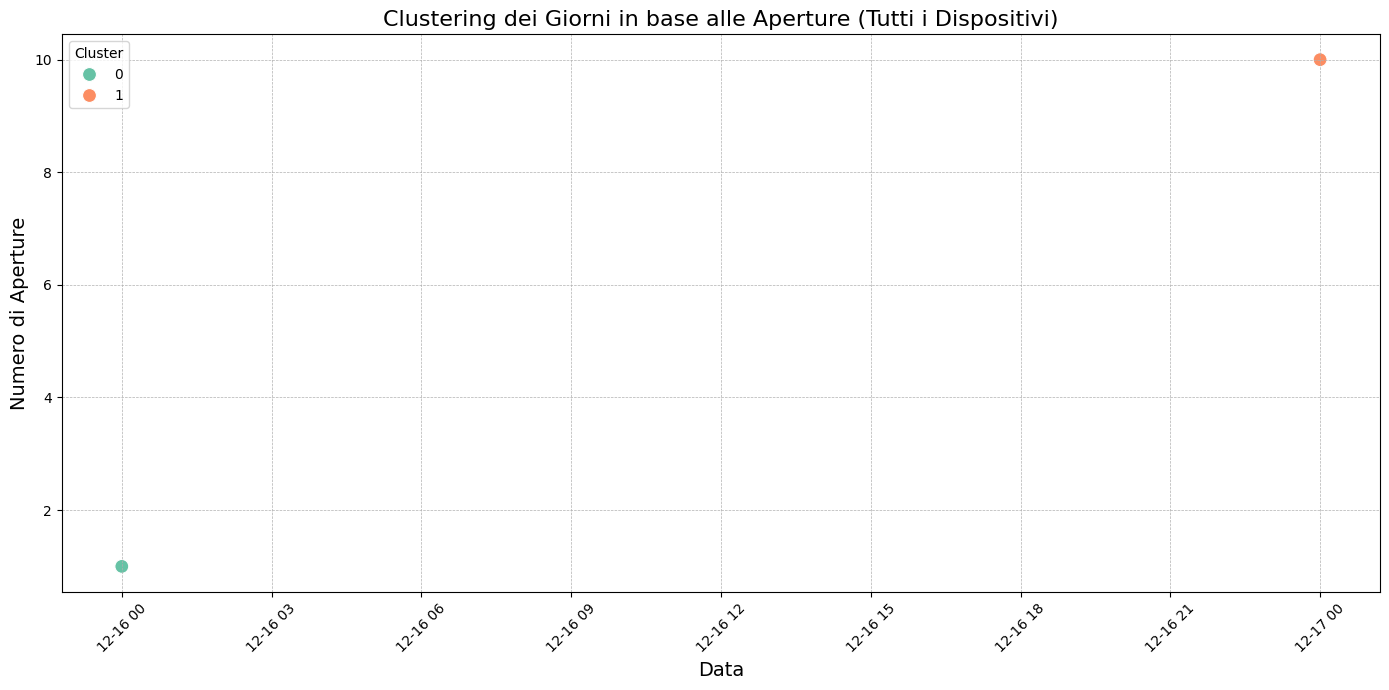

Media delle Aperture per Cluster:
cluster
0     1.0
1    10.0
Name: opens, dtype: float64


In [12]:
if 'timestamp' in logs_df.columns:
    logs_df['date'] = logs_df['timestamp'].dt.date

    daily_opens = logs_df[logs_df['action'] == 'porta aperta'].groupby('date').size().reset_index(name='opens')

    if len(daily_opens) < 2:
        print("Non ci sono abbastanza dati di aperture per eseguire il clustering.")
    else:
        from sklearn.cluster import KMeans
        import matplotlib.pyplot as plt
        import seaborn as sns

        # Scegli n_clusters=2 se pochi dati, altrimenti 3
        n_clusters = 2 if len(daily_opens) < 5 else 3

        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(daily_opens[['opens']])
        daily_opens['cluster'] = kmeans.labels_

        plt.figure(figsize=(14,7))
        sns.scatterplot(x='date', y='opens', data=daily_opens, hue='cluster', palette='Set2', s=100)
        plt.xticks(rotation=45)
        plt.title("Clustering dei Giorni in base alle Aperture (Tutti i Dispositivi)", fontsize=16)
        plt.xlabel("Data", fontsize=14)
        plt.ylabel("Numero di Aperture", fontsize=14)
        plt.legend(title='Cluster')
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.tight_layout()
        plt.show()

        cluster_means = daily_opens.groupby('cluster')['opens'].mean()
        print("Media delle Aperture per Cluster:")
        print(cluster_means)


## Clustering (K-Means) su Allarmi 

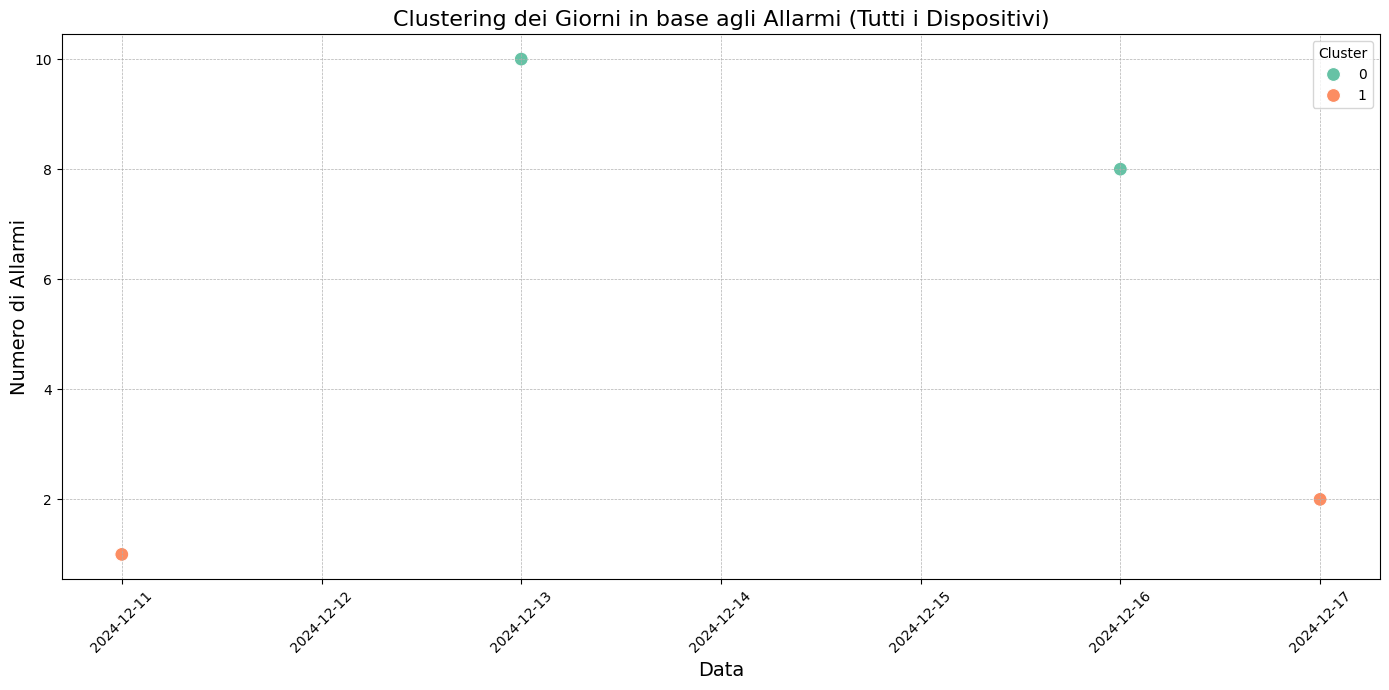

Media degli Allarmi per Cluster:
cluster
0    9.0
1    1.5
Name: alarms, dtype: float64


In [13]:
# Cella: Clustering per Allarmi (Aggregato)
if 'action' in logs_df.columns:
    alarms_df = logs_df[logs_df['action'].str.contains("allarme_on|EFF", case=False, na=False)]
    if alarms_df.empty:
        print("Non ci sono allarmi per tutti i dispositivi.")
    else:
        alarms_df['date'] = alarms_df['timestamp'].dt.date
        daily_alarms = alarms_df.groupby('date').size().reset_index(name='alarms')

        if len(daily_alarms) < 2:
            print("Non ci sono abbastanza dati di allarmi per eseguire il clustering.")
        else:
            from sklearn.cluster import KMeans
            import matplotlib.pyplot as plt
            import seaborn as sns

            n_clusters = 2 if len(daily_alarms) < 5 else 3
            kmeans = KMeans(n_clusters=n_clusters, random_state=42)
            kmeans.fit(daily_alarms[['alarms']])
            daily_alarms['cluster'] = kmeans.labels_

            plt.figure(figsize=(14,7))
            sns.scatterplot(x='date', y='alarms', data=daily_alarms, hue='cluster', palette='Set2', s=100)
            plt.xticks(rotation=45)
            plt.title("Clustering dei Giorni in base agli Allarmi (Tutti i Dispositivi)", fontsize=16)
            plt.xlabel("Data", fontsize=14)
            plt.ylabel("Numero di Allarmi", fontsize=14)
            plt.legend(title='Cluster')
            plt.grid(True, which='both', linestyle='--', linewidth=0.5)
            plt.tight_layout()
            plt.show()

            cluster_means = daily_alarms.groupby('cluster')['alarms'].mean()
            print("Media degli Allarmi per Cluster:")
            print(cluster_means)


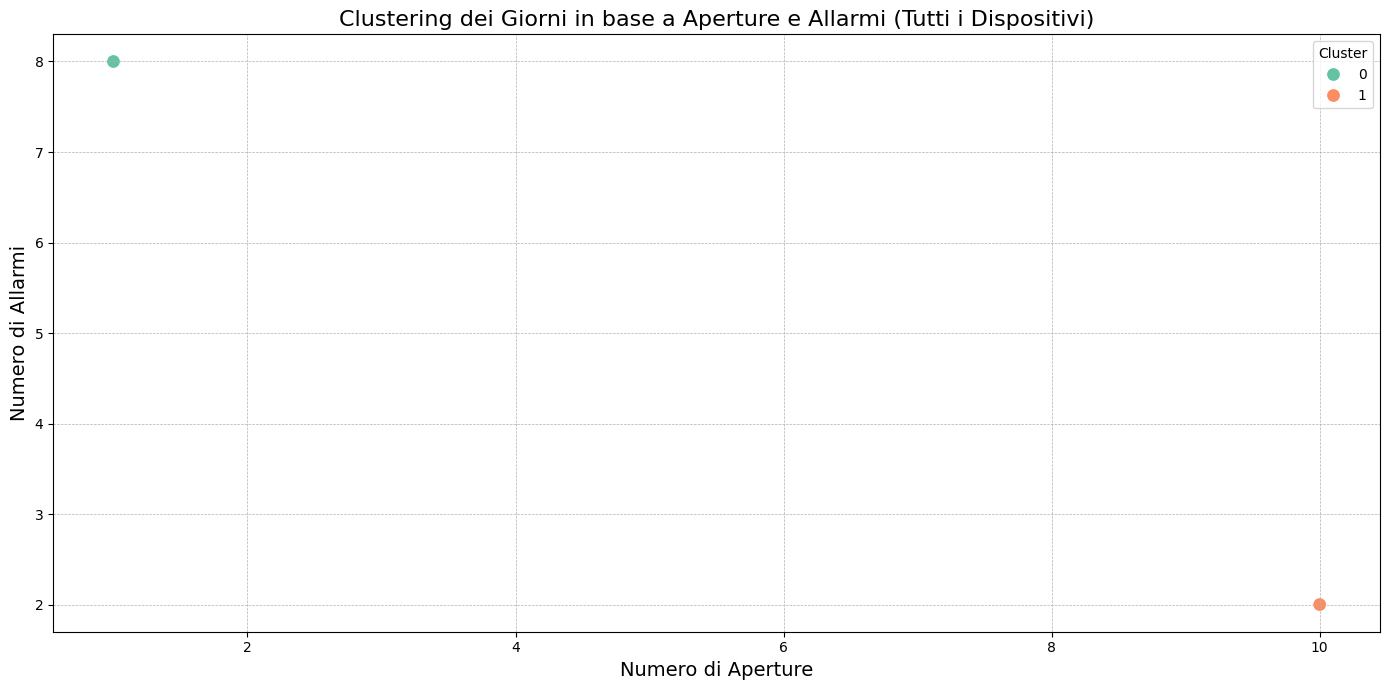

Media di Aperture e Allarmi per Cluster:
         opens  alarms
cluster               
0          1.0     8.0
1         10.0     2.0


In [14]:
from sklearn.cluster import KMeans
import numpy as np

# Cella: Clustering per anomalie su aperture e allarmi (aggregato)
if 'timestamp' in logs_df.columns:
    logs_df['date'] = logs_df['timestamp'].dt.date

    # Conteggio aperture per giorno
    daily_opens = logs_df[logs_df['action'] == 'porta aperta'].groupby('date').size().reset_index(name='opens')
    # Conteggio allarmi per giorno
    alarms_df = logs_df[logs_df['action'].str.contains("allarme_on|EFF", case=False, na=False)]
    daily_alarms = alarms_df.groupby('date').size().reset_index(name='alarms') if not alarms_df.empty else pd.DataFrame(columns=['date','alarms'])

    # Merge dei dati: aperture e allarmi per giorno
    daily_stats = pd.merge(daily_opens, daily_alarms, on='date', how='left')
    daily_stats['alarms'] = daily_stats['alarms'].fillna(0)

    # Evita l'errore se non ci sono dati sufficienti
    if len(daily_stats) < 2:
        print("Non ci sono abbastanza dati per eseguire il clustering.")
    else:
        # Esegui il clustering con K-Means
        X = daily_stats[['opens','alarms']].copy()

        # Scegli n_clusters=3 (modifica se necessario)
        kmeans = KMeans(n_clusters=2, random_state=42)
        kmeans.fit(X)
        daily_stats['cluster'] = kmeans.labels_

        # Visualizza i cluster
        plt.figure(figsize=(14,7))
        sns.scatterplot(x='opens', y='alarms', data=daily_stats, hue='cluster', palette='Set2', s=100)
        plt.title("Clustering dei Giorni in base a Aperture e Allarmi (Tutti i Dispositivi)", fontsize=16)
        plt.xlabel("Numero di Aperture", fontsize=14)
        plt.ylabel("Numero di Allarmi", fontsize=14)
        plt.legend(title='Cluster')
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.tight_layout()
        plt.show()

        # Possiamo anche stampare la media di ciascun cluster per capire meglio le anomalie
        cluster_means = daily_stats.groupby('cluster')[['opens','alarms']].mean()
        print("Media di Aperture e Allarmi per Cluster:")
        print(cluster_means)


## Clusterizzare i giorni in base al numero di prenotazioni, aperture porta, effrazioni.

## Creiamo un DataFrame aggregato giornalmente

In [15]:
logs_df['date'] = logs_df['timestamp'].dt.date
daily_stats = logs_df.groupby('date')['action'].value_counts().unstack(fill_value=0)
daily_stats.head()


action,allarme_off,allarme_on,aperta,chiusa,porta aperta,porta chiusa,unlock
date,,,,,,,
2024-12-11,0,1,2,3,0,0,4
2024-12-13,4,10,2,3,0,0,5
2024-12-16,7,8,7,8,1,2,10
2024-12-17,2,2,0,0,10,10,5


## Normalizza i dati e usa KMeans per clusterizzare i giorni

In [16]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(daily_stats)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X)

daily_stats['cluster'] = clusters
daily_stats.head()

# Osserva le medie per cluster
print(daily_stats.groupby('cluster').mean())


action   allarme_off  allarme_on  aperta  chiusa  porta aperta  porta chiusa  \
cluster                                                                        
0                5.5         9.0     4.5     5.5           0.5           1.0   
1                2.0         2.0     0.0     0.0          10.0          10.0   
2                0.0         1.0     2.0     3.0           0.0           0.0   

action   unlock  
cluster          
0           7.5  
1           5.0  
2           4.0  
